In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [2]:
# Constants
DATA = 'RestrictedImageNet' # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 8
NOISE_SCALE = 20
NUM_ACTIVATIONS = 3
VIS_CORRECT = False


DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset

In [3]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset restricted_imagenet..


In [4]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}

model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()

for m in model.modules():
    if isinstance(m, ch.nn.Linear):
        linear_weight = m.weight

=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


In [5]:
# Select examples to visualize (either correct or wrongly classified)
img_list, targ_list, pred_list, title_list = [], [], [], []
inp_list = []
for _, (img, targ) in data_iterator:

    out, _ = model(img)
    pred = out.argmax(1)
    corr = pred.eq(targ.cuda())
    sel_idx = corr if VIS_CORRECT else ~corr
    for x, y in zip([img_list, targ_list, pred_list], [img, targ, pred]):
        x.append(y[sel_idx])
    title_list.extend([f"targ: {CLASSES[int(t)]}, pred: {CLASSES[int(p)]}" 
                       for t, p in zip(targ[sel_idx], pred[sel_idx])])
    
img_list = ch.cat(img_list)[:BATCH_SIZE]
targ_list = ch.cat(targ_list)[:BATCH_SIZE]
pred_list = ch.cat(pred_list)[:BATCH_SIZE]
title_list = np.stack(title_list)[:BATCH_SIZE]

with ch.no_grad():
    (_, rep_list), _ = model(img_list.cuda(), with_latent=True)

In [6]:
# Find activations that contribute maximally to logit for predicted class
max_act = []
for rep, pred in zip(rep_list, pred_list):
    dp = (rep * linear_weight[pred]).detach().cpu().numpy()
    max_act.append(np.argsort(dp)[::-1][:NUM_ACTIVATIONS])
max_act = np.concatenate(max_act)

In [7]:
# Custom loss to maximize select activation
def activation_loss(mod, inp, targ):
    _, rep = mod(inp, with_latent=True, fake_relu=True)
    loss = ch.mean(ch.gather(rep, 1, targ), dim=1)
    return loss, None

In [8]:
# PGD parameters
kwargs = {
    'custom_loss': activation_loss,
    'constraint':'2',
    'eps': 40,
    'step_size': 1,
    'iterations': 60, 
    'do_tqdm': False,
    'targeted': False,
}

In [9]:
# Seed input
inp_list = []
for i in range(len(img_list)):
    inp_list.extend(img_list[i:i+1].repeat(NUM_ACTIVATIONS, 1, 1, 1))
inp_list = ch.stack(inp_list)

# Maximize top-k activations
_, xadv = model(inp_list, ch.tensor(max_act)[:, None], make_adv=True, **kwargs)
xadv = xadv.detach().cpu().reshape(BATCH_SIZE, NUM_ACTIVATIONS, xadv.shape[1], xadv.shape[2], xadv.shape[3])

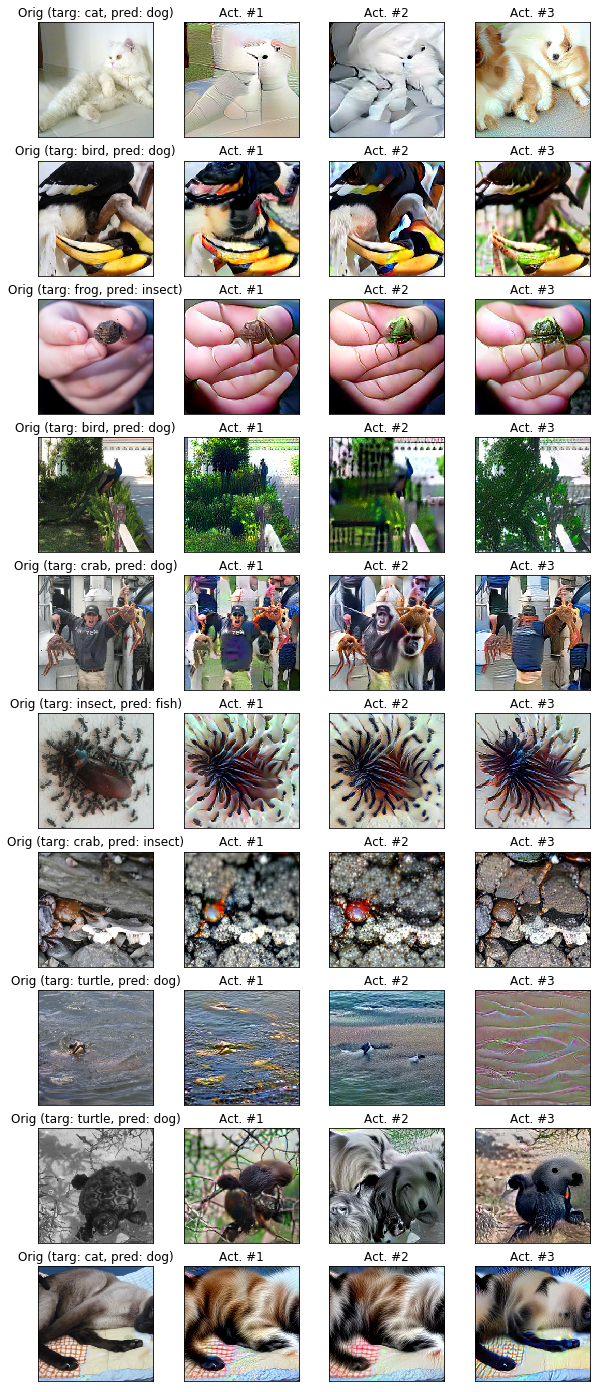

In [10]:
# Visualize results
res = ch.cat([img_list[:, None, ...], xadv], dim=1).cpu()

show_image_row(res,
               tlist=[[f"Orig ({t})", "Act. #1", "Act. #2", "Act. #3"] for t in title_list])